In [146]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['figure.dpi'] = 80
# matplotlib.rcParams['figure.figsize'] = [17, 4]
matplotlib.rcParams['axes.grid'] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# !pip install --upgrade pip --proxy=https://web-proxy.labs.hpecorp.net:8088
import sys
sys.version_info

sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)

In [6]:
import sys
sys.path.insert(0, '../')

from lib_data import *
from lib_nn_dpe import NN_dpe

In [8]:
load_workspace(vars(), '../data/20190821-051552-mnist_xs')
load_workspace(vars(), '../data/20200130-100802-mnist_config')

c:\users\can\.venv\py37\lib\site-packages\dill\_dill.py:472: UserWarning: This figure was saved with matplotlib version 3.1.1 and is unlikely to function correctly.
  obj = StockUnpickler.load(self)


Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, 
Loaded: xs, new_lin_cor_fc1, new_lin_cor_fc2, lin_cor_conv, finalGfc, finalGconv, weights, 


In [9]:
del train_images
del train_labels
# del test_images
# del test_labels
del xs

In [10]:
from lib_ecc import *

## Construct NN

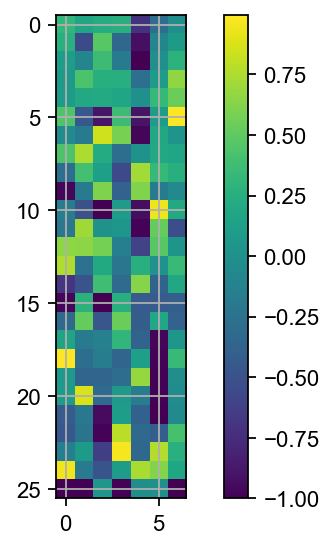

In [11]:
nn = NN_dpe(weights)

nn.Gratio = 100e-6

plt.imshow(nn.Mconv); plt.colorbar()

In [12]:
nn.Gratio

0.0001

## ECC matrix

7 4.0 7.0
The number of redundancy column is chosen to be the smallest even number 8
(26, 15)


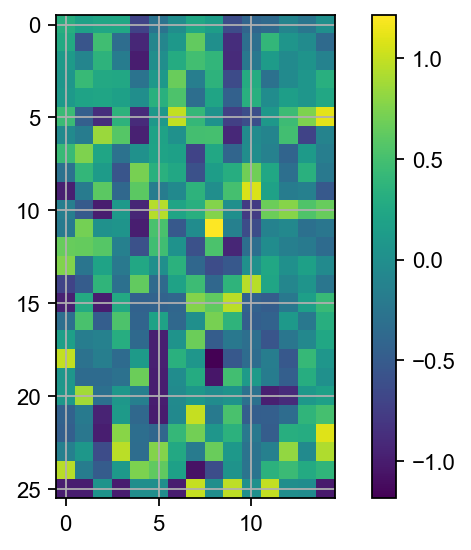

In [13]:
from dpeECC import dpeECC

delta = 1
Delta = 8 * delta

m = nn.Mconv.shape[0]
k = nn.Mconv.shape[1]

print(k, np.ceil(np.sqrt(k+1))+1, 2*k/(np.floor(Delta/(2*delta))-2))

ecc = dpeECC(nn.Mconv, delta, Delta)
M_conv_ecc = ecc.encode()

print('The number of redundancy column is chosen to be the smallest even number', ecc.r)
print(M_conv_ecc.shape)

plt.imshow(M_conv_ecc); plt.colorbar()

Convert to conductance

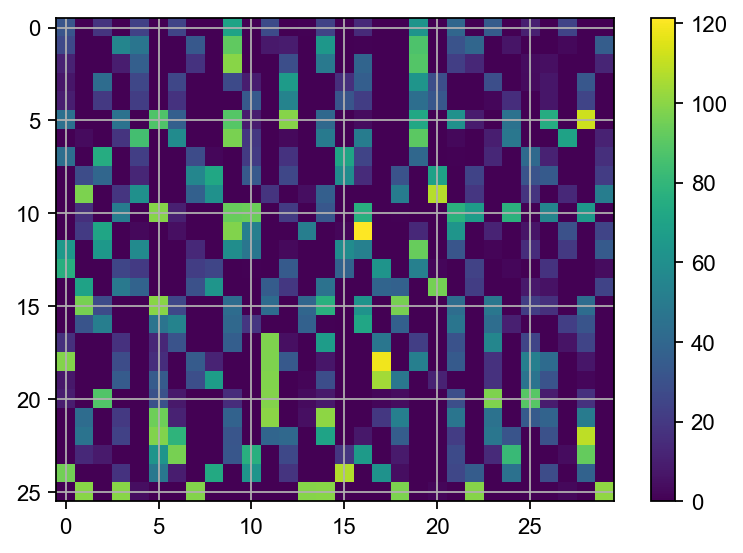

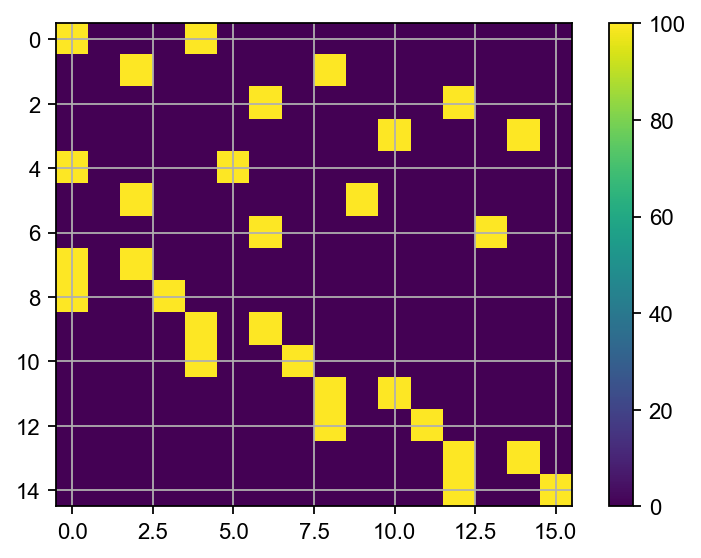

In [14]:
G_conv_ecc = weight2conductance(M_conv_ecc)
G_parity_ecc = weight2conductance(ecc.H.T)

plt.figure(1)
plt.imshow(G_conv_ecc * 1e6); plt.colorbar()

plt.figure(2)
plt.imshow(G_parity_ecc * 1e6); plt.colorbar()

## Program the array

In [15]:
from dpe import DPE

dpe = DPE('COM3')
dpe.set_clock(50)

DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


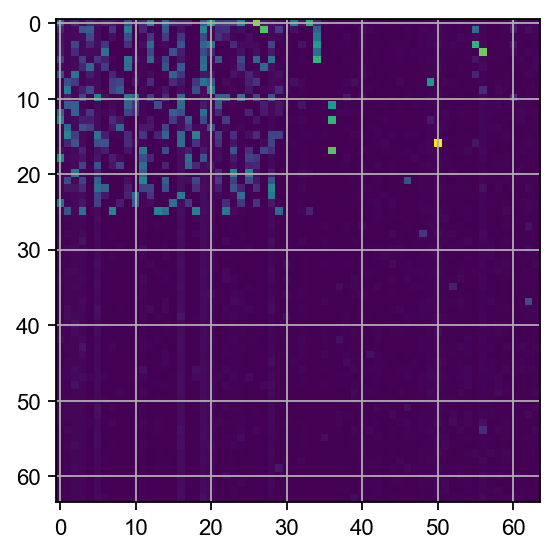

In [17]:
g = dpe.read(1, method='fast')
plt.imshow(g)

In [147]:
Gtarget = np.zeros((64,64))

rs = 0
cs = 0

Gtarget[rs:rs+G_conv_ecc.shape[0], cs:cs+G_conv_ecc.shape[1]] = G_conv_ecc

Gtarget[rs+G_conv_ecc.shape[0]: rs+G_conv_ecc.shape[0]*2, 
        cs+G_conv_ecc.shape[1]: cs+G_conv_ecc.shape[1]*2] = G_conv_ecc

Msel = np.ones((64,64))
# Msel[20:,20:] = 1
# Msel[Gtarget<4e-6] = 0

# Msel = np.zeros((64,64))
# Msel[rs:rs+G_conv_ecc.shape[0], cs:cs+G_conv_ecc.shape[1]] = 1
# Msel[rs+G_conv_ecc.shape[0]: rs+G_conv_ecc.shape[0]*2, 
#         cs+G_conv_ecc.shape[1]: cs+G_conv_ecc.shape[1]*2] = 1

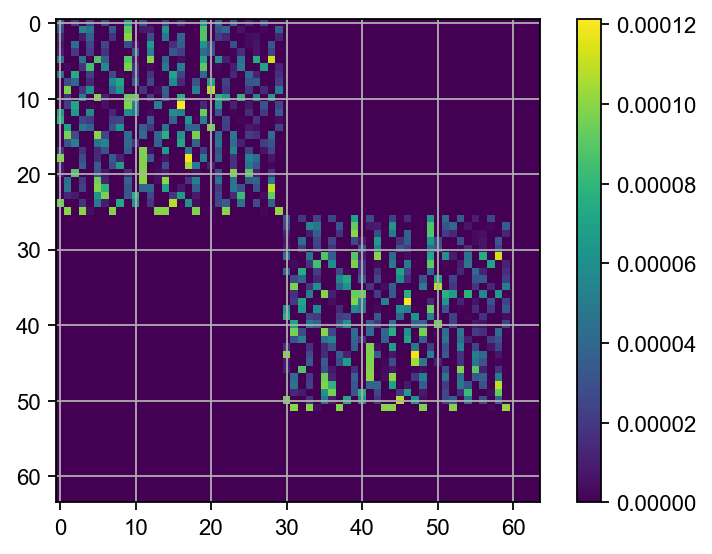

In [148]:
plt.imshow(Gtarget)
plt.colorbar()

In [185]:
data = dpe.tune_conductance(1,  Gtarget, saveHistory=True, maxSteps=1000, method='slow',
                           vSetRamp=[1, 3, 0.25], vGateSetRamp=[0.5, 1.4, 0.05],
                           vResetRamp=[0.3, 1.5, 0.05], vGateResetRamp=[5.0, 5.5, 0.5], 
                           Twidth=10e-6, TwidthReset=1e-3,  Msel=Msel, Gtol_in=4e-6, Gtol_out=10e-6, numReads=1)

Start programming, step=999, maxBound=80 yield= 86.06% - 93.16%
267.0 devices to be programmed...reset 104.0, set 243.0
Setting 207 devices...
Programming with external timing Twidth=10.000 us
Resetting 65 devices...
Programming with external timing Twidth=1000.000 us


....

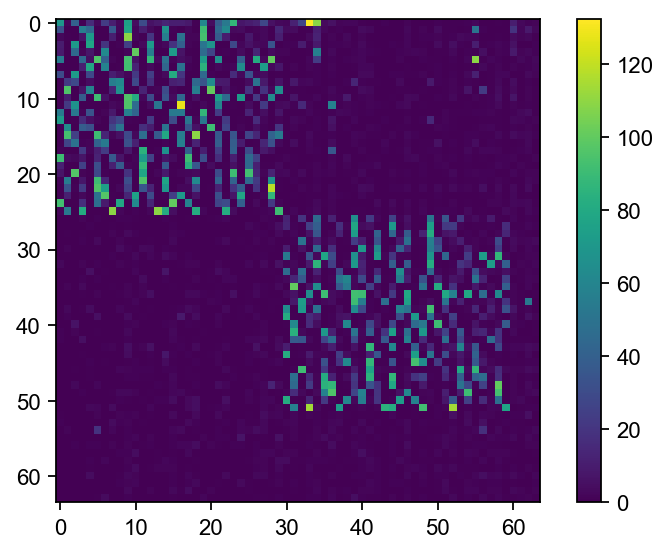

In [150]:
g2 = dpe.read(1, method='slow')
plt.imshow(g2*1e6); plt.colorbar()
plt.grid(False)

....

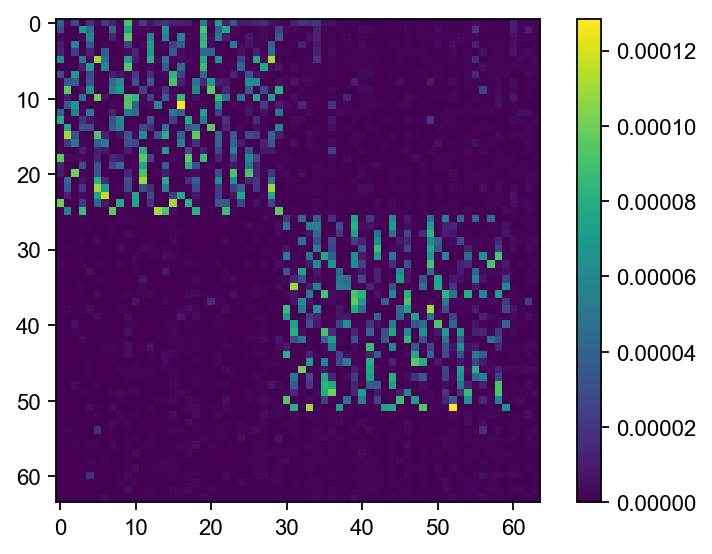

In [154]:
g2 = dpe.read(1, method='slow')

plt.imshow(g2)
# plt.imshow(g2[rs:rs+G_conv_ecc.shape[0], cs:cs+G_conv_ecc.shape[1]]*1e6); plt.colorbar()
plt.grid(False)
plt.colorbar()

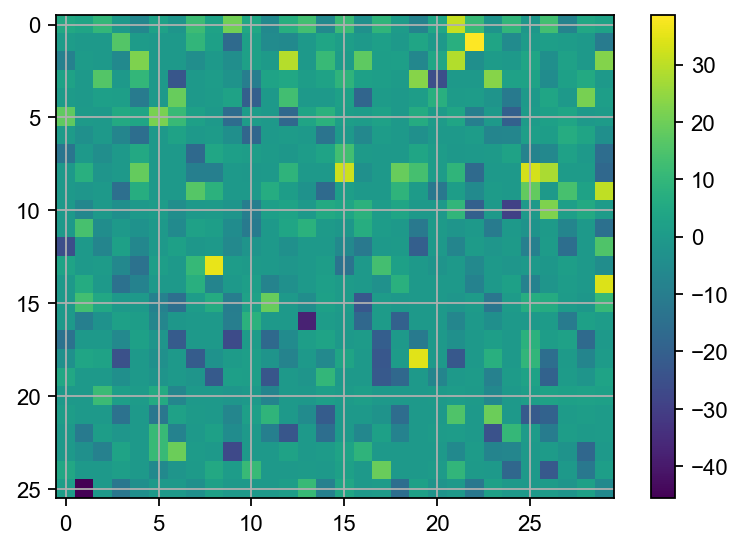

In [155]:
plt.imshow((g2-Gtarget)[rs:rs+G_conv_ecc.shape[0], cs:cs+G_conv_ecc.shape[1]]* 1e6 )
plt.colorbar()

In [153]:
data = dpe.tune_conductance(1,  Gtarget, saveHistory=True, maxSteps=300, method='slow',
                           vSetRamp=[1, 3, 0.25], vGateSetRamp=[0.5, 1.4, 0.05],
                           vResetRamp=[0.3, 2.2, 0.05], vGateResetRamp=[5.0, 5.5, 0.5], 
                           Twidth=10e-6, TwidthReset=10e-3,  Msel=Msel, Gtol_in=20e-6, Gtol_out=40e-6, numReads=1)

Start programming, step=299, maxBound=6 yield= 97.12% - 99.90%
4.0 devices to be programmed...reset 3.0, set 7.0
Setting 1 devices...
Programming with external timing Twidth=10.000 us
Resetting 3 devices...
Programming with external timing Twidth=10000.000 us


In [195]:
Msel = np.zeros((64,64))
Msel[20:,20:] = 1

Text(0, 0.5, 'Count')

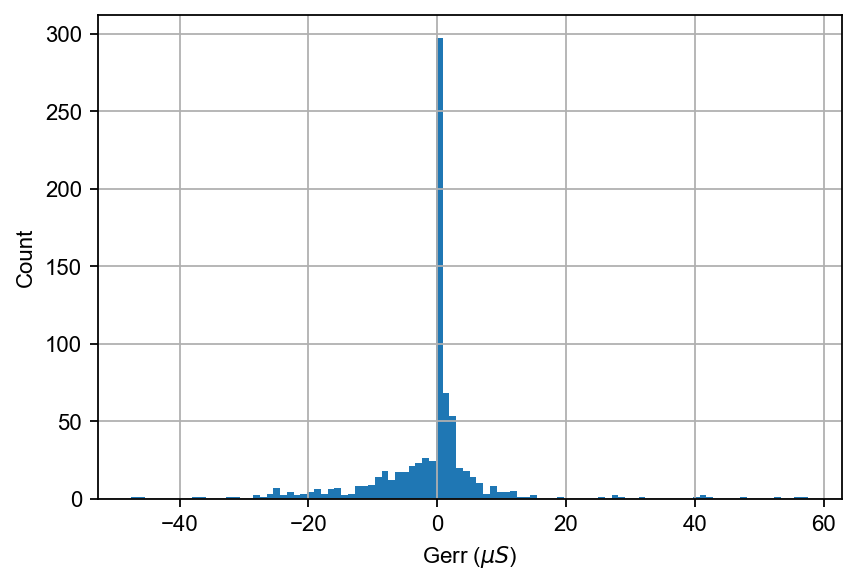

In [87]:
gdiff = (g2-Gtarget)[rs:rs+G_conv_ecc.shape[0], cs:cs+G_conv_ecc.shape[1]]* 1e6 

_ = plt.hist((gdiff.reshape(-1)), 100)

plt.xlabel('Gerr ($\mu S$)')
plt.ylabel('Count')

# plt.xlim((-30, 30))

## CNN test

In [167]:
i = 0

N_IMG = 1

vectors_list = []
output_list = []

for img, lab in tqdm(zip(test_images, test_labels), total=N_IMG):
    i += 1

    vectors = nn._conv_flattern(img)
    output = dpe.multiply(
            1, 
            vectors, 
#             c_sel=[cs, cs+G_conv_ecc.shape[1]], 
#             r_start=rs, mode=0, Tdly=500) / (nn.Gratio)
            c_sel=[0, 0+G_conv_ecc.shape[1]], 
            r_start=0, mode=0, Tdly=500) / (nn.Gratio)
    
    vectors_list.append(vectors)
    output_list.append(output)
    
    if i >= N_IMG:
        break

In [168]:
vectors = np.concatenate(vectors_list, axis=1)
output = np.concatenate(output_list, axis=0)

In [169]:
output_soft = vectors.T @ G_conv_ecc / nn.Gratio

(400, 30) (400, 30)


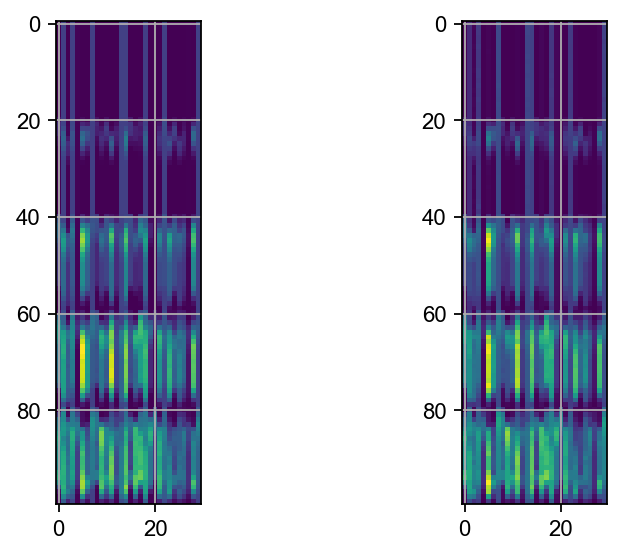

In [170]:
plt.subplot(121)
plt.imshow(output_soft[:100])

plt.subplot(122)
plt.imshow(output[:100])

print(output.shape, output_soft.shape)

Core output

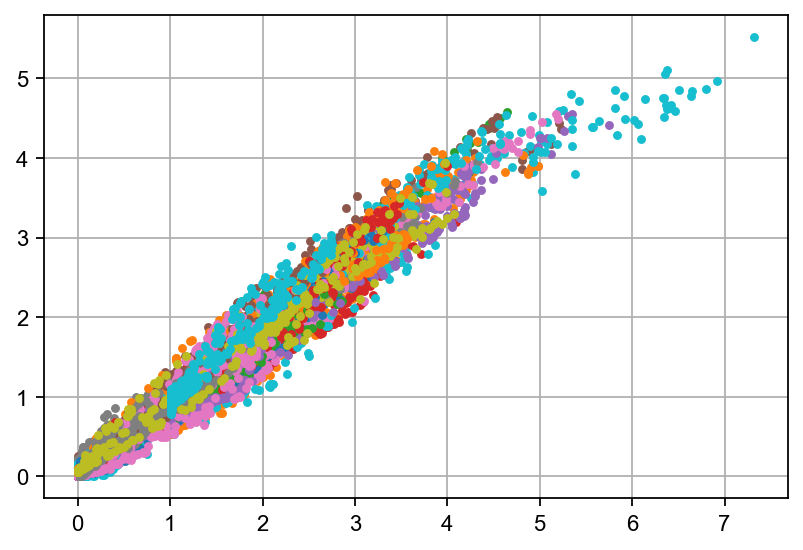

In [171]:
for c in range(output.shape[1]):
    plt.plot(output_soft[:,c], output[:,c], '.')

Linear correction

In [172]:
lin_cor_conv = []
for c in range(output.shape[1]):
    lin_cor_conv.append( np.polyfit(output[:,c], output_soft[:,c], 1))

In [173]:
output_cor = dpe.lin_corr(output, lin_cor_conv)

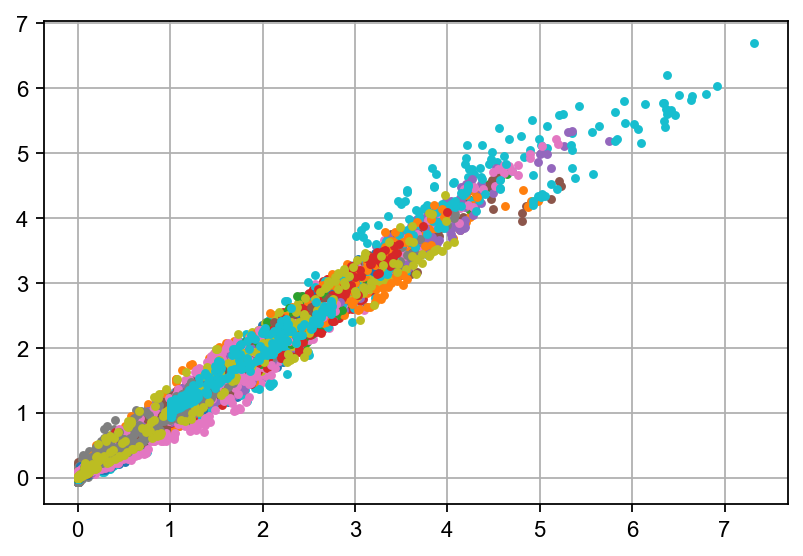

In [174]:
for c in range(output.shape[1]):
    plt.plot(output_soft[:,c], output_cor[:,c], '.')

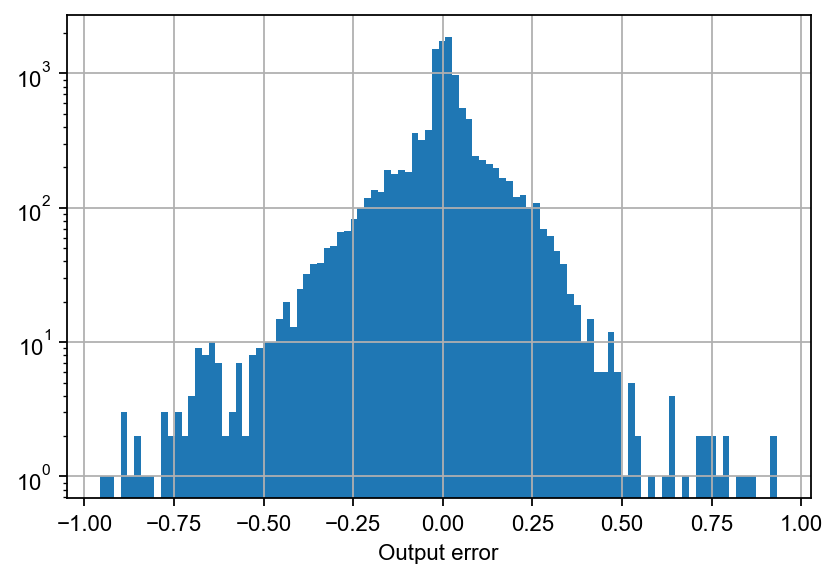

In [175]:
_ = plt.hist((output_cor - output_soft ).reshape(-1), 100)
plt.xlabel('Output error')

plt.yscale('log')

In [176]:
# save_workspace(vars(), note='programming1', skip_mat=True)

## Plot the difference

In [177]:
delta = 0.2
Delta = 8 * delta

m = nn.Mconv.shape[0]
k = nn.Mconv.shape[1]

ecc = dpeECC(nn.Mconv, delta, Delta)

In [178]:
i = 0

n_detected = 0
n_corrected = 0
n_other = 0

y_pred = []

y1_raw_list = []
y1_ecc_list = []
y1_soft_list = []

N_IMG = 1

for img, lab in tqdm(zip(test_images[:N_IMG], test_labels[:N_IMG]), total=N_IMG):
    i += 1

    vectors = nn._conv_flattern(img)
    
    # HARDWARE CALL
    output = dpe.multiply(
            1, 
            vectors, 
            c_sel=[cs, cs+G_conv_ecc.shape[1]], 
            r_start=rs, mode=0, Tdly=500) / (nn.Gratio)
    
#     Linear correction
    output = dpe.lin_corr(output, lin_cor_conv)
    
    y1 = output[:, ::2] - output[:, 1::2]
    
    output_soft = vectors.T @ G_conv_ecc / nn.Gratio
    y1_soft = output_soft[:, ::2] - output_soft[:, 1::2]
    
    y1_raw_list.append(y1.copy())
    y1_soft_list.append(y1_soft.copy())
    
    # ECC
    S = (y1 @ G_parity_ecc / nn.Gratio)
    S = S[:, ::2] - S[:, 1::2]

    for s, yy in zip(S, y1):
        ecc_loc, ecc_range = ecc.decode_w_syndrome(s)
        
        if ecc_loc != -1:
            if ecc_loc == -2:
                # Detected but could not be corrected
                n_detected += 1
                
            elif ecc_loc >=0:
                # Correct
                n_corrected += 1
                yy[ecc_loc] -= (ecc_range[0]+ecc_range[1])/2
            else:
                n_other += 1
                
    y1_ecc_list.append(y1.copy())
    
    
    k = nn.Gconv.shape[1] //2
    
    x = y1[:, :k]

    x = x.reshape(20, 20, -1)

    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    x1 = np.append(x1, 1)

    y = x1.T @ finalGfc
    y = y[::2] - y[1::2]

    y_pred.append(y.argmax())
    

In [179]:
n_detected, n_corrected, n_other

(61, 54, 0)

In [180]:
y1_raw = np.array(y1_raw_list)
y1_soft = np.array(y1_soft_list)
y1_ecc = np.array(y1_ecc_list)

(-1.5, 1.5)

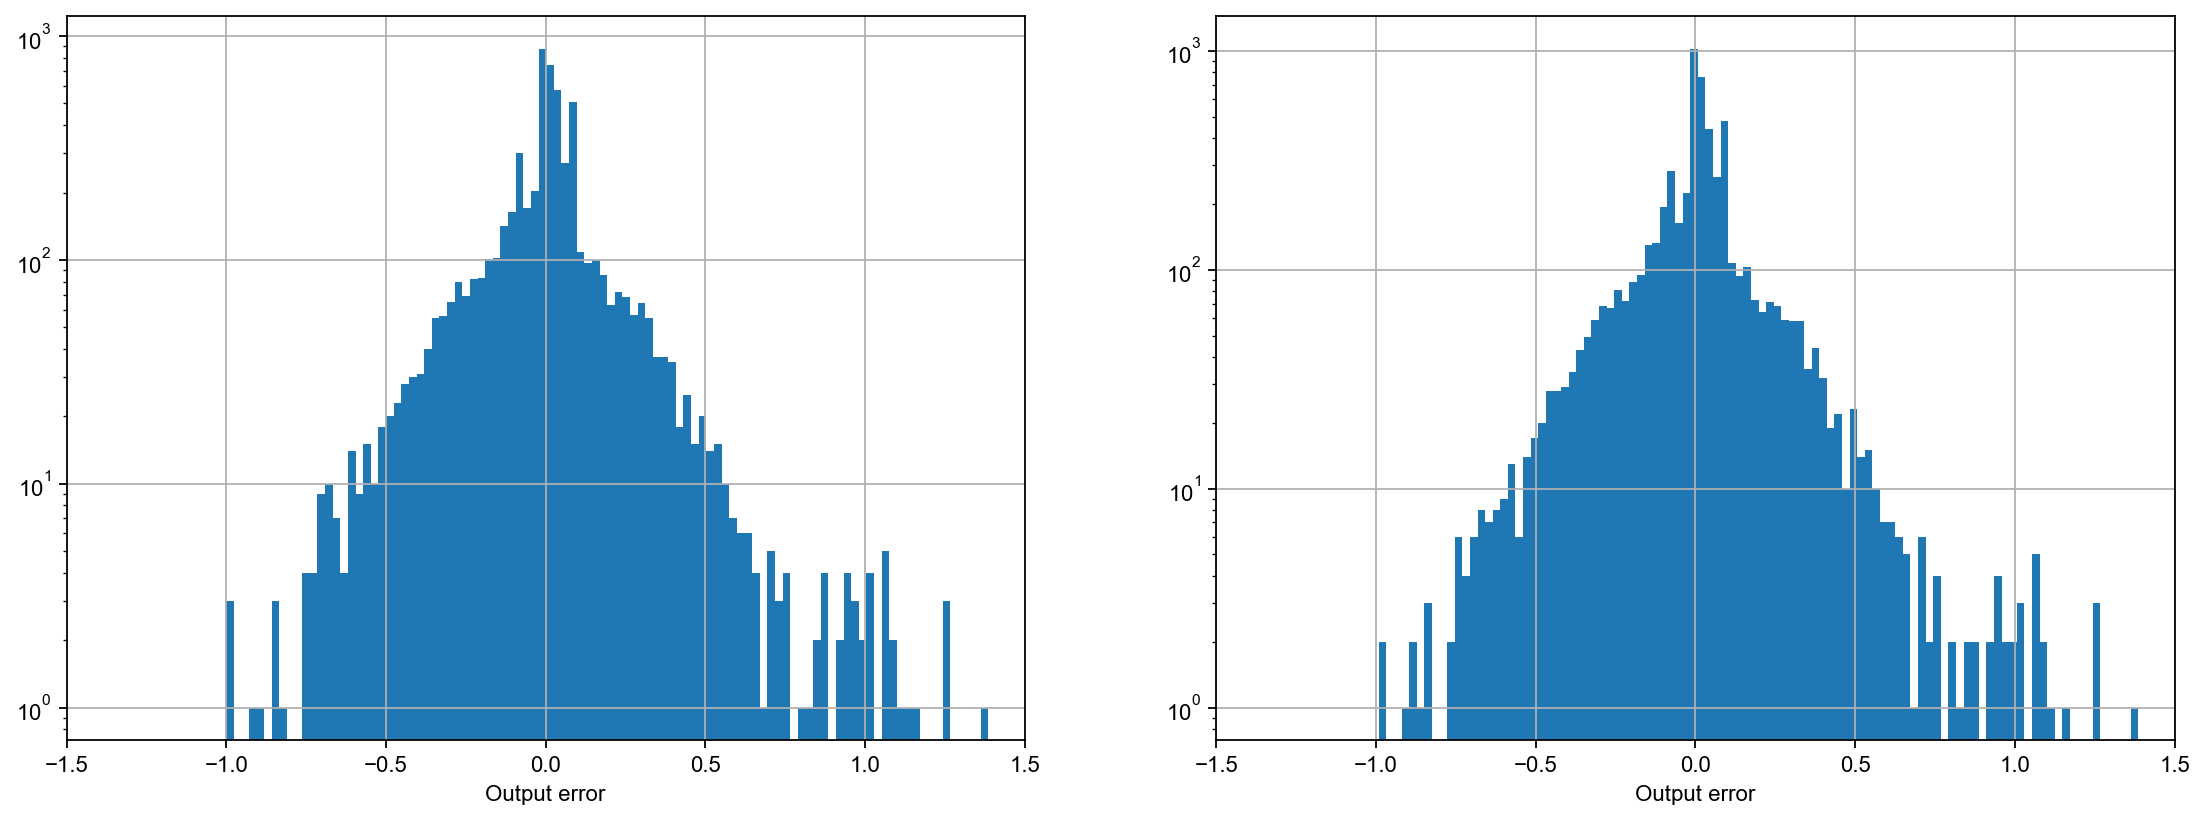

In [181]:
plt.figure(figsize=(17, 6))

plt.subplot(1,2,1)

_ = plt.hist((y1_raw - y1_soft ).reshape(-1), 100)
plt.xlabel('Output error')
plt.yscale('log')
plt.xlim((-1.5,1.5))

plt.subplot(1,2,2)
_ = plt.hist((y1_ecc - y1_soft ).reshape(-1), 100)
plt.xlabel('Output error')
plt.yscale('log')
plt.xlim((-1.5,1.5))

In [182]:
err_raw = (y1_raw - y1_soft).reshape(-1)

np.std(err_raw)

0.20901294135740012

In [183]:
err_ecc = (y1_ecc - y1_soft).reshape(-1)

np.std(err_ecc)

0.2064100854774908

Text(0, 0.5, 'Cummulative number of error')

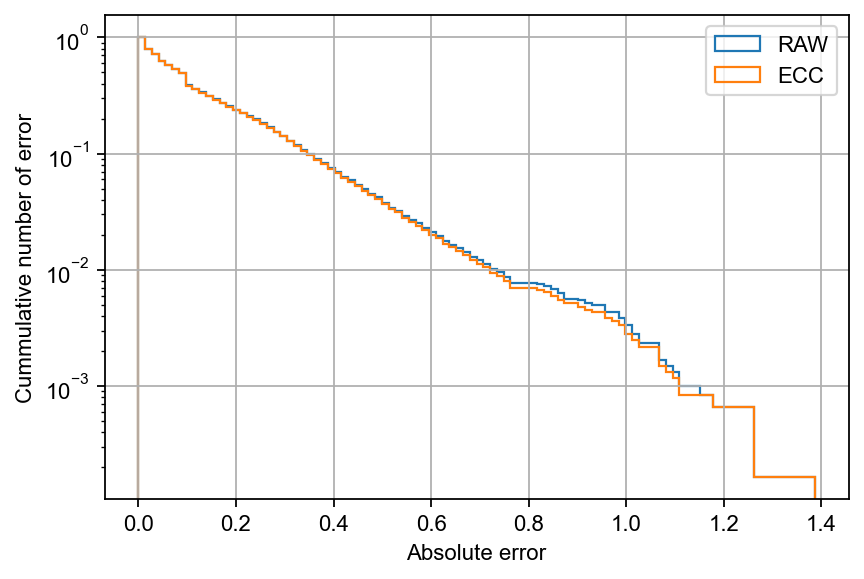

In [184]:
_ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
        label='RAW', bins=100)

_ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
        label='ECC', bins=100)

plt.legend()

plt.yscale('log')

plt.xlabel('Absolute error')
plt.ylabel('Cummulative number of error')

## Plot the difference 2

In [241]:
delta = 0.15
Delta = 8 * delta

m = nn.Mconv.shape[0]
k = nn.Mconv.shape[1]

ecc = dpeECC(nn.Mconv, delta, Delta)

In [245]:
# n_detected = 0
# n_corrected = 0
# n_other = 0

# y_pred = []

# y1_raw_list = []
# y1_ecc_list = []
# y1_soft_list = []

output_list = []

t_list = []

g_list = []

# N_IMG = 1

img = test_images[0]
lab = test_labels[0]

import time
ts = time.time()

for i in tqdm(range(10000)):
# for img, lab in tqdm(zip(test_images[:N_IMG], test_labels[:N_IMG]), total=N_IMG):
    vectors = nn._conv_flattern(img)
    
    # HARDWARE CALL
    output = dpe.multiply(
            0, 
            vectors, 
            c_sel=[20, 50], 
            r_start=20, mode=0, Tdly=500) / (nn.Gratio)
    
    output_list.append(output.copy())
    t_list.append(time.time() - ts)
    
    g_list.append(dpe.read(0, method='fast')[20:20+G_conv_ecc.shape[0], 20:20+G_conv_ecc.shape[1]])
    
    if i%1000 == 0:
        save_workspace({
            'output_list':output_list,
            't_list':t_list,
            'g_list':g_list
        }, note='repeat')


save_workspace({
    'output_list':output_list,
    't_list':t_list,
    'g_list':g_list
}, note='repeat')
#     Linear correction
#     output = dpe.lin_corr(output, lin_cor_conv)
    
#     y1 = output[:, ::2] - output[:, 1::2]
    
#     output_soft = vectors.T @ G_conv_ecc / nn.Gratio
#     y1_soft = output_soft[:, ::2] - output_soft[:, 1::2]
    
#     y1_raw_list.append(y1.copy())
#     y1_soft_list.append(y1_soft.copy())
    
    # ECC
#     y1 = correct_ecc(y1, ecc)
                
#     y1_ecc_list.append(y1.copy())
    
    
#     k = nn.Gconv.shape[1] //2
    
#     x = y1[:, :k]
    
#     print(x.shape)
    
#     y = dense(x, nn, finalGfc)

#     y_pred.append(y.argmax())

Saving output_list(<class 'list'>), t_list(<class 'list'>), g_list(<class 'list'>), to 20200601-153108-repeat.pkl
Saving output_list(<class 'list'>), t_list(<class 'list'>), g_list(<class 'list'>), to 20200601-153108-repeat.mat
Saving output_list(<class 'list'>), t_list(<class 'list'>), g_list(<class 'list'>), to 20200601-165330-repeat.pkl
Saving output_list(<class 'list'>), t_list(<class 'list'>), g_list(<class 'list'>), to 20200601-165330-repeat.mat
Saving output_list(<class 'list'>), t_list(<class 'list'>), g_list(<class 'list'>), to 20200601-181531-repeat.pkl
Saving output_list(<class 'list'>), t_list(<class 'list'>), g_list(<class 'list'>), to 20200601-181531-repeat.mat
Saving output_list(<class 'list'>), t_list(<class 'list'>), g_list(<class 'list'>), to 20200601-193028-repeat.pkl
Saving output_list(<class 'list'>), t_list(<class 'list'>), g_list(<class 'list'>), to 20200601-193028-repeat.mat
Saving output_list(<class 'list'>), t_list(<class 'list'>), g_list(<class 'list'>), to 2

In [246]:
save_workspace(vars(), note='repeat-all')

Saving In(<class 'list'>), Out(<class 'dict'>), weights(<class 'numpy.ndarray'>), test_images(<class 'numpy.ndarray'>), test_labels(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), img_idx(<class 'int'>), image(<class 'numpy.ndarray'>), vectors(<class 'numpy.ndarray'>), outputs(<class 'numpy.ndarray'>), software(<class 'numpy.ndarray'>), c(<class 'int'>), x(<class 'numpy.ndarray'>), y(<class 'numpy.ndarray'>), mat_contents(<class 'dict'>), finalGconv(<class 'numpy.ndarray'>), g1(<class 'numpy.ndarray'>), g2(<class 'numpy.ndarray'>), linear_factors_conv(<class 'numpy.ndarray'>), acc(<class 'list'>), result(<class 'numpy.ndarray'>), x1(<class 'numpy.ndarray'>), new_lin_cor_fc1(<class 'list'>), new_lin_cor_fc2(<class 'list'>), lin_cor_conv(<class 'list'>), finalGfc(<class 'numpy.ndarray'>), delta(<class 'float'>), Delta(<class 'float'>), m(<class 'int'>), k(<class 'int'>), M_conv_ecc(<class 'numpy.ndarray'>), G_conv_ecc(<class 'numpy.ndarray'>), G_parity_ecc(<class 'numpy.ndarray'>),

TypeError: can't pickle _RawIOBase objects

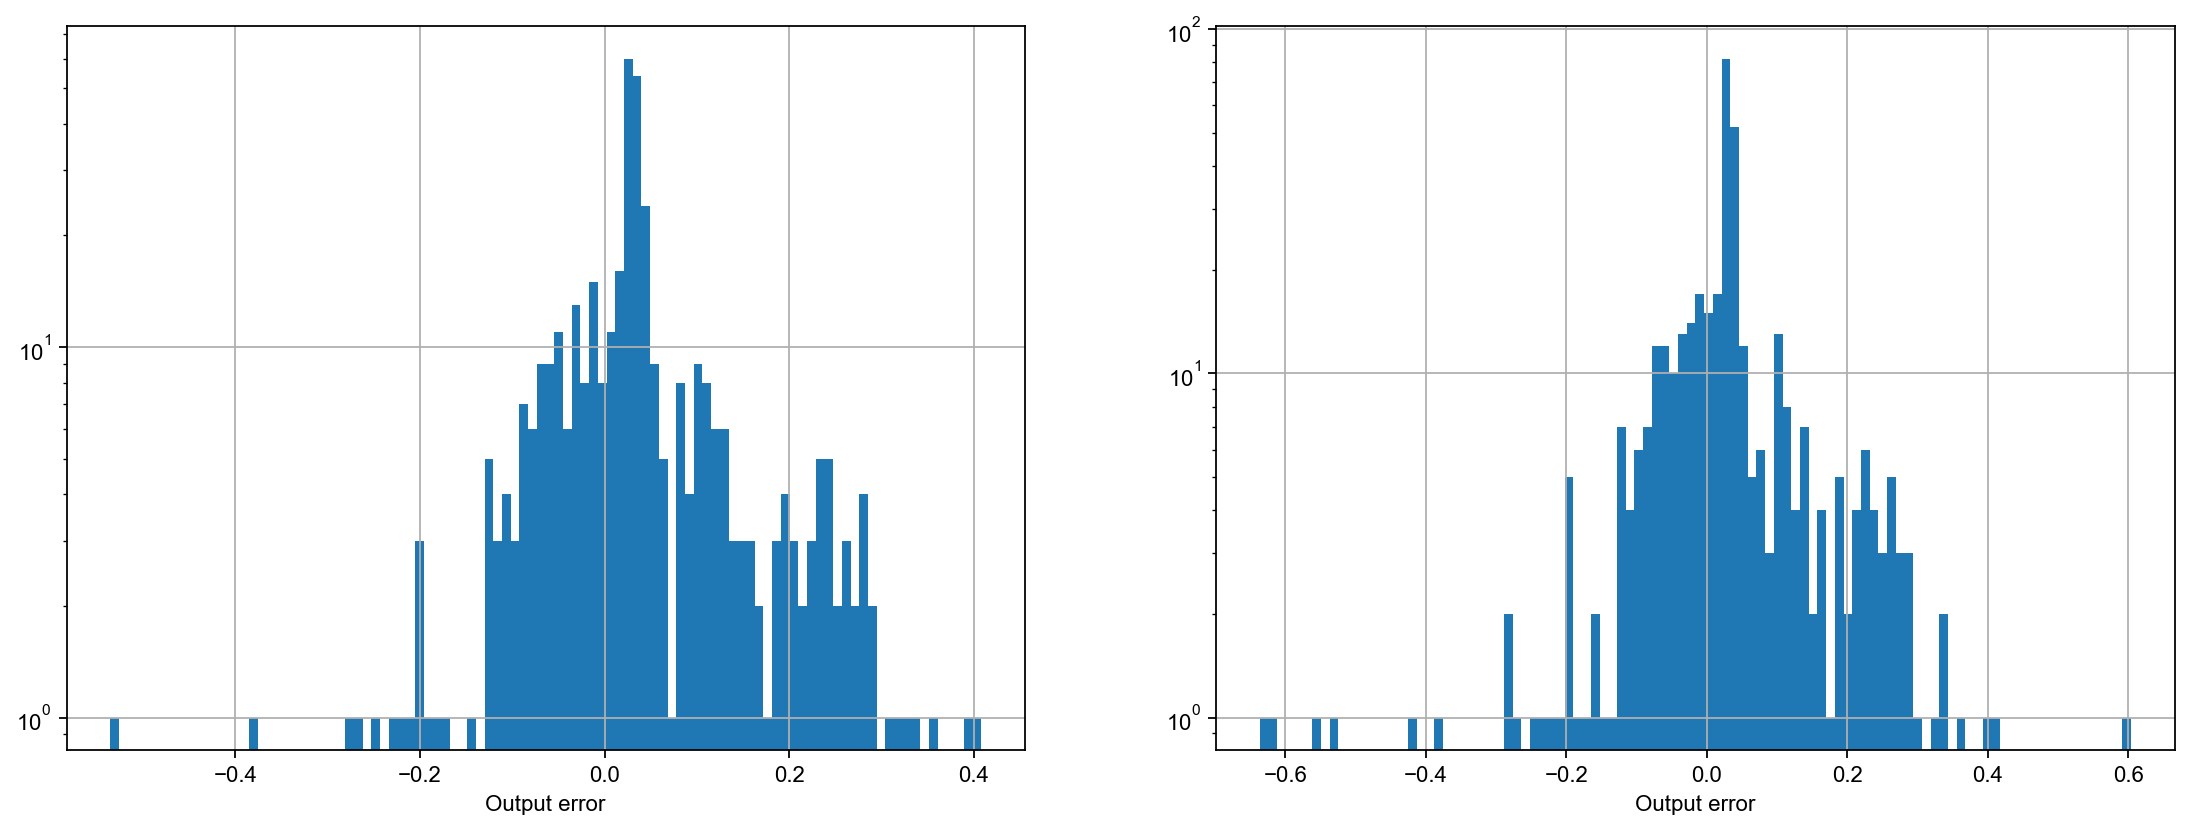

In [230]:
y1_raw = np.array(y1_raw_list)[:,:,0]
y1_soft = np.array(y1_soft_list)[:,:,0]
y1_ecc = np.array(y1_ecc_list)[:,:,0]

plt.figure(figsize=(17, 6))

plt.subplot(1,2,1)

_ = plt.hist((y1_raw - y1_soft ).reshape(-1), 100)
plt.xlabel('Output error')
plt.yscale('log')
# plt.xlim((-1.5,1.5))

plt.subplot(1,2,2)
_ = plt.hist((y1_ecc - y1_soft ).reshape(-1), 100)
plt.xlabel('Output error')
plt.yscale('log')
# plt.xlim((-1.5,1.5))

Text(0, 0.5, 'Cummulative number of error')

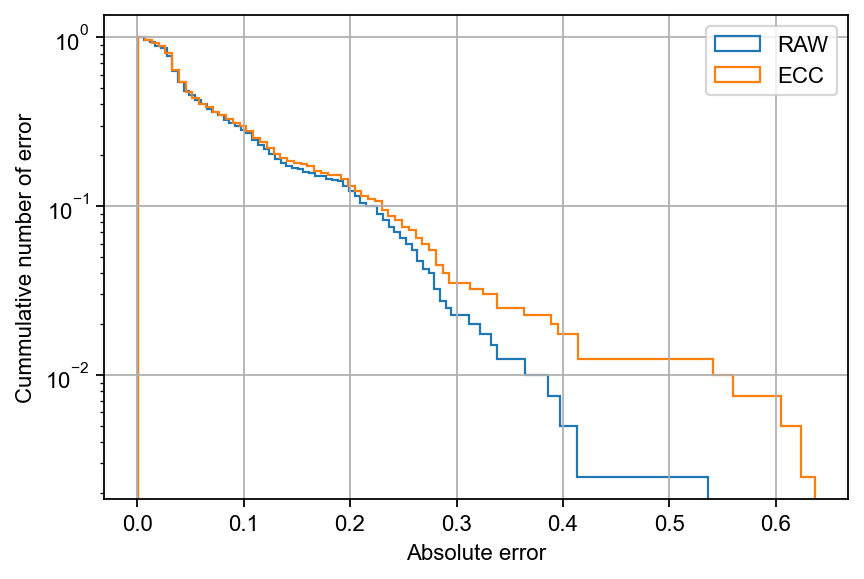

In [232]:
err_raw = (y1_raw - y1_soft).reshape(-1)
err_ecc = (y1_ecc - y1_soft).reshape(-1)

_ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
        label='RAW', bins=100)

_ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
        label='ECC', bins=100)

plt.legend()

plt.yscale('log')

plt.xlabel('Absolute error')
plt.ylabel('Cummulative number of error')

## Explore delta parameter

In [250]:
np.array(y1_raw_list).shape

(1, 400, 15)

In [251]:
delta_list = np.arange(0.02, 0.5, 0.02)

y1_raw_list = []
y1_list = []

n_detected = 0
n_corrected = 0
n_other = 0

for delta in tqdm(delta_list):

    Delta = 8 * delta

    ecc = dpeECC(nn.Mconv, delta, Delta)

    img = test_images[0]


    vectors = nn._conv_flattern(img)

    # HARDWARE CALL
    output = dpe.multiply(
            0, 
            vectors, 
            c_sel=[20, 50], 
            r_start=20, mode=0, Tdly=500) / (nn.Gratio)

    # Linear correction
    output = dpe.lin_corr(output, lin_cor_conv)

    y1 = output[:, ::2] - output[:, 1::2]

    y1_raw = y1.copy()

    # ECC
    S = (y1 @ G_parity_ecc / nn.Gratio)
    S = S[:, ::2] - S[:, 1::2]

    for s, yy in zip(S, y1):
        ecc_loc, ecc_range = ecc.decode_w_syndrome(s)

        if ecc_loc != -1:
            if ecc_loc == -2:
                # Detected but could not be corrected
                n_detected += 1

            elif ecc_loc >=0:
                # Correct
                n_corrected += 1
                yy[ecc_loc] -= (ecc_range[0]+ecc_range[1])/2
            else:
                n_other += 1
                
    y1_raw_list.append(y1_raw)
    y1_list.append(y1)

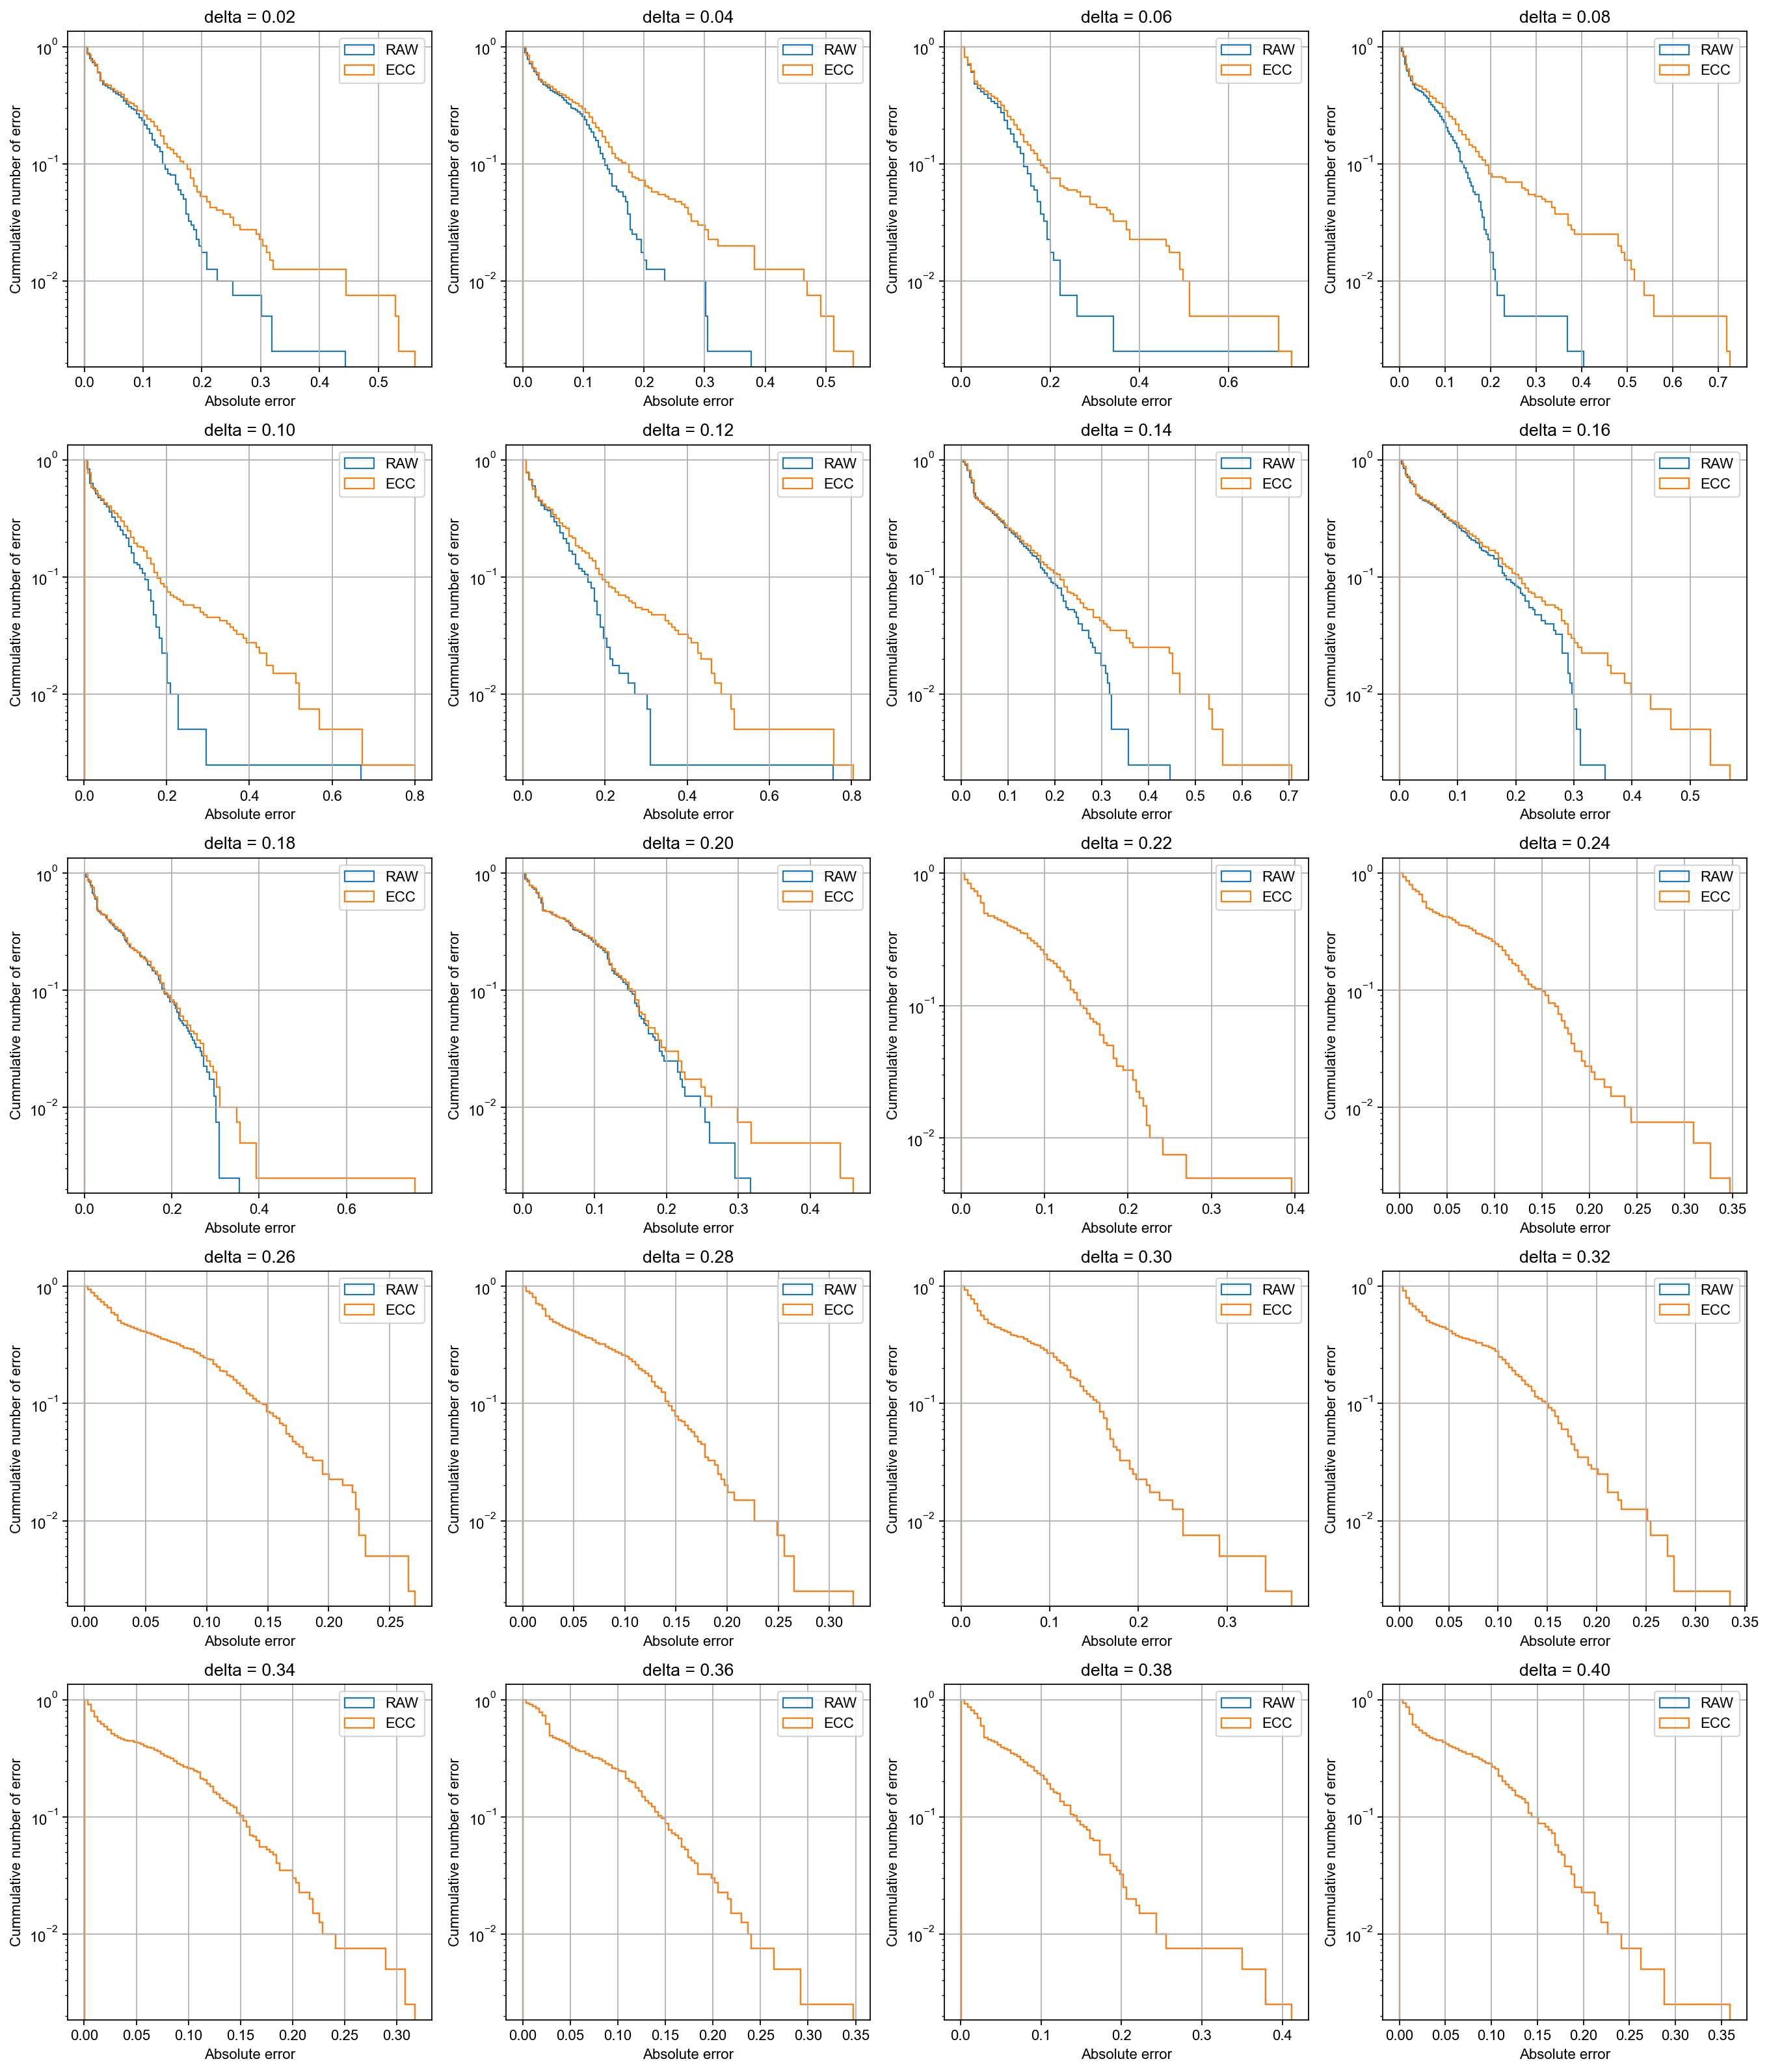

In [254]:
output_soft = vectors.T @ G_conv_ecc / nn.Gratio
y1_soft = output_soft[:, ::2] - output_soft[:, 1::2]

plt.figure(figsize=(17,20))

# for i in range(len(y1_list)):
for i in range(20):
    
    plt.subplot(5,4,i+1)

    y1_raw = y1_raw_list[i]
    y1 = y1_list[i]


    err_raw = (y1_raw - y1_soft)[:,0].reshape(-1)
    err_ecc = (y1 - y1_soft)[:,0].reshape(-1)


    _ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
            label='RAW', bins=100)

    _ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
            label='ECC', bins=100)

    plt.legend()

    plt.yscale('log')

    plt.xlabel('Absolute error')
    plt.ylabel('Cummulative number of error')
    
    plt.title(f'delta = {delta_list[i]:.2f}')
    
plt.tight_layout()

# CNN test

In [141]:
def correction(y1):
    # ECC
    S = (y1 @ G_parity_ecc / nn.Gratio)
    S = S[:, ::2] - S[:, 1::2]

    for s, yy in zip(S, y1):
        ecc_loc, ecc_range = ecc.decode_w_syndrome(s)
        
        if ecc_loc != -1:
            if ecc_loc == -2:
                # Detected but could not be corrected
#                 n_detected += 1
                pass
            elif ecc_loc >=0:
                # Correct
#                 n_corrected += 1
                yy[ecc_loc] -= (ecc_range[0]+ecc_range[1])/2
            else:
                pass
#                 n_other += 1
                
    return y1

def dense(x):
    x = x.reshape(20, 20, -1)

    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    x1 = np.append(x1, 1)


    y = x1.T @ finalGfc
    y = y[::2] - y[1::2]

    return y.argmax()

In [142]:
delta = 0.2
Delta = 8 * delta
ecc = dpeECC(nn.Mconv, delta, Delta)
    
# n_detected = 0
# n_corrected = 0
# n_other = 0

y_pred = []
y_pred_raw = []

cnn_y1_list = []

N_IMG = 10000

pbar = tqdm(enumerate(zip(test_images[:N_IMG], test_labels[:N_IMG])), total=N_IMG)
for i, (img, lab) in pbar:

    vectors = nn._conv_flattern(img)
    
    # HARDWARE CALL
    output = dpe.multiply(
            0, 
            vectors, 
            c_sel=[20, 50], 
            r_start=20, mode=0, Tdly=500) / (nn.Gratio)
    
    # Linear correction
    output = dpe.lin_corr(output, lin_cor_conv)
    
    y1 = output[:, ::2] - output[:, 1::2]
    
    y1_raw = y1.copy()
    
    cnn_y1_list.append(y1.copy())
    
    # Correction
    y1 = correction(y1)
    
    k = nn.Gconv.shape[1] //2
    
    y_pred.append(dense(y1[:, :k]))
    
    y_pred_raw.append(dense(y1_raw[:, :k]))
    
    pbar.set_description(f"Accuracy=" +
                         f"{np.mean(y_pred_raw==test_labels[:i+1])*100:.2f}%->"
                         f"{np.mean(y_pred==test_labels[:i+1])*100:.2f}%")
    
    if i%1000 == 0:
        save_workspace({'y1_list': cnn_y1_list}, note='cnn-ecc', skip_mat=True)
        
save_workspace({'y1_list': cnn_y1_list}, note='cnn-ecc', skip_mat=True)

Saving y1_list(<class 'list'>), to 20200516-223108-cnn-ecc.pkl
Saving y1_list(<class 'list'>), to 20200516-233420-cnn-ecc.pkl
Saving y1_list(<class 'list'>), to 20200517-004121-cnn-ecc.pkl
Saving y1_list(<class 'list'>), to 20200517-014905-cnn-ecc.pkl
Saving y1_list(<class 'list'>), to 20200517-025704-cnn-ecc.pkl
Saving y1_list(<class 'list'>), to 20200517-040445-cnn-ecc.pkl
Saving y1_list(<class 'list'>), to 20200517-051223-cnn-ecc.pkl
Saving y1_list(<class 'list'>), to 20200517-062047-cnn-ecc.pkl
Saving y1_list(<class 'list'>), to 20200517-072837-cnn-ecc.pkl
Saving y1_list(<class 'list'>), to 20200517-083619-cnn-ecc.pkl

Saving y1_list(<class 'list'>), to 20200517-094343-cnn-ecc.pkl


In [143]:
len(cnn_y1_list)

10000

## Analyze the effect of ECC

Looks like the the array is not in a good shape. We have achieved a much better accuracy than this one.

In [144]:
y_pred = []

for y1 in tqdm(cnn_y1_list, total=len(test_labels)):
    y1 = correction(y1.copy())
    
    k = nn.Gconv.shape[1] //2

    # Remaining layer
    y_pred.append(dense(y1[:, :k]))

print(f"Accuracy={np.mean(y_pred==test_labels)*100:.2f}%")


Accuracy=97.25%


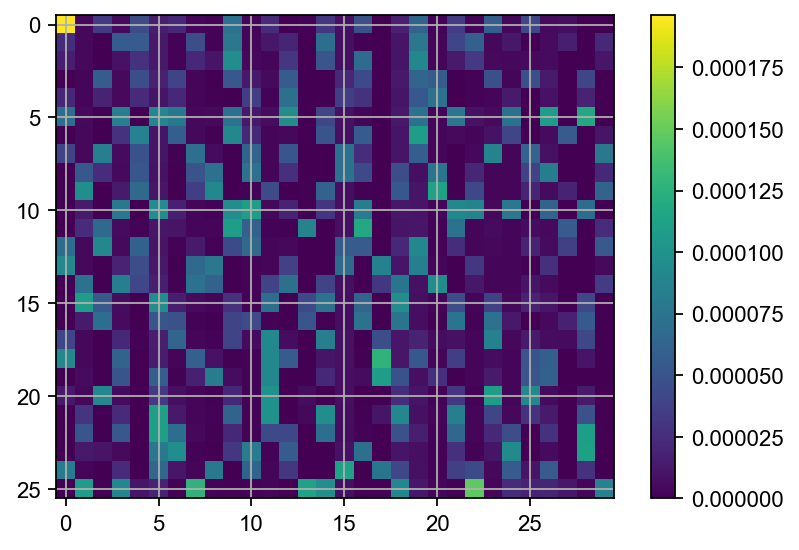

In [147]:
g_cnn = dpe.read(0, method='fast')[20:20+26, 20:20+30]
plt.imshow(g_cnn); plt.colorbar()

In [148]:
y_pred = []

for y1 in tqdm(cnn_y1_list, total=len(test_labels)):
#     y1 = correction(y1.copy())
    
    k = nn.Gconv.shape[1] //2

    # Remaining layer
    y_pred.append(dense(y1[:, :k]))

print(f"Accuracy={np.mean(y_pred==test_labels)*100:.2f}%")


Accuracy=95.30%


In [149]:
delta_list = np.arange(0.02, 0.5, 0.02)
acc_list = []

for delta in tqdm(delta_list):
    
    Delta = 8 * delta
    ecc = dpeECC(nn.Mconv, delta, Delta)

    y_pred = []

    for y1 in tqdm(cnn_y1_list, total=len(test_labels)):
        
        y1 = correction(y1.copy())
        k = nn.Gconv.shape[1] //2

        # Remaining layer
        y_pred.append(dense(y1[:, :k]))

    acc = np.mean(y_pred==test_labels)*100
    acc_list.append(acc)
    print(f"delta={delta}, Accuracy={acc:.2f}%")


delta=0.02, Accuracy=95.31%



delta=0.04, Accuracy=95.54%



delta=0.06, Accuracy=95.65%



delta=0.08, Accuracy=95.81%



delta=0.1, Accuracy=96.02%



delta=0.12000000000000001, Accuracy=96.16%



delta=0.13999999999999999, Accuracy=96.51%



delta=0.16, Accuracy=96.93%



delta=0.18, Accuracy=97.24%



delta=0.19999999999999998, Accuracy=97.25%



delta=0.22, Accuracy=97.28%



delta=0.24, Accuracy=97.30%



delta=0.26, Accuracy=97.24%



delta=0.28, Accuracy=97.02%



delta=0.30000000000000004, Accuracy=96.82%



delta=0.32, Accuracy=96.67%



delta=0.34, Accuracy=96.60%



delta=0.36000000000000004, Accuracy=96.31%



delta=0.38, Accuracy=96.10%



delta=0.4, Accuracy=96.04%



delta=0.42000000000000004, Accuracy=95.91%



delta=0.44, Accuracy=95.86%



delta=0.46, Accuracy=95.76%



delta=0.48000000000000004, Accuracy=95.68%



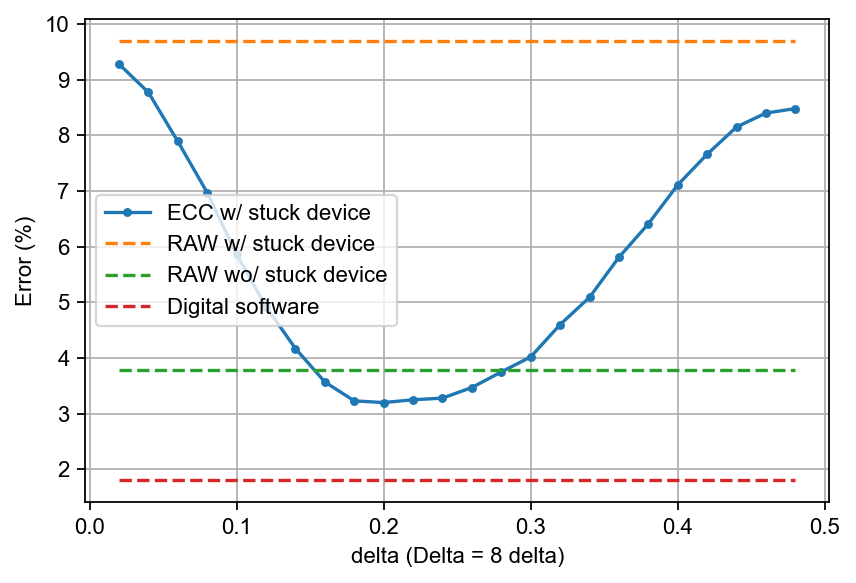

In [474]:
plt.plot(delta_list, [100-acc for acc in acc_list], '.-', label='ECC w/ stuck device')

plt.plot(delta_list, [100-90.31 for _ in delta_list], '--', label='RAW w/ stuck device')
plt.plot(delta_list, [100-96.21 for _ in delta_list], '--', label='RAW wo/ stuck device')
plt.plot(delta_list, [100-98.20 for _ in delta_list], '--', label='Digital software')

plt.xlabel('delta (Delta = 8 delta)')
plt.ylabel('Error (%)')
# plt.yscale('log')
plt.legend()

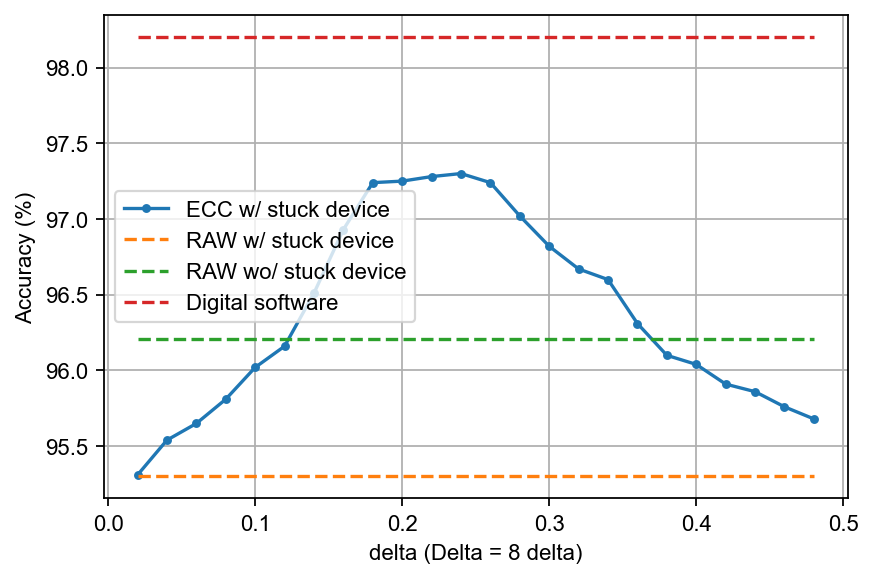

In [150]:
plt.plot(delta_list, [acc for acc in acc_list], '.-', label='ECC w/ stuck device')

plt.plot(delta_list, [95.30 for _ in delta_list], '--', label='RAW w/ stuck device')
plt.plot(delta_list, [96.21 for _ in delta_list], '--', label='RAW wo/ stuck device')
plt.plot(delta_list, [98.20 for _ in delta_list], '--', label='Digital software')

plt.xlabel('delta (Delta = 8 delta)')
plt.ylabel('Accuracy (%)')
plt.legend()

# Log

## First complete CNN experiment

"20200516-163148-cnn-ecc.pkl"

In [138]:
delta = 0.2
Delta = 8 * delta
ecc = dpeECC(nn.Mconv, delta, Delta)

N_IMG = 10000

y_pred = []

y1_soft_list = []
y1_hard_list = []
y1_ecc_list = []

n_corrected = 0

pbar = tqdm(enumerate(zip(test_images[:N_IMG], test_labels[:N_IMG])), total=N_IMG)
for i, (img, lab) in pbar:

    vectors = nn._conv_flattern(img)
    
    output_soft = vectors.T @ G_conv_ecc / nn.Gratio
    y1_soft = output_soft[:, ::2] - output_soft[:, 1::2]
    y1_soft_list.append(y1_soft.copy())
    
    y1_hardware = cnn_y1_list[i].copy()
    y1_hard_list.append(cnn_y1_list[i])
    
    y1 = y1_hardware
    
#     ECC
#     S = (y1 @ G_parity_ecc / nn.Gratio)
#     S = S[:, ::2] - S[:, 1::2]

    for r, (s, yy) in enumerate(zip(S, y1)):
        ecc_loc, ecc_range = ecc.decode(yy)
        
        if ecc_loc != -1:
            if ecc_loc == -2:
                # Detected but could not be corrected
                n_detected += 1
                
            elif ecc_loc >=0:
                # Correct
                n_corrected += 1
                yy[ecc_loc] -= (ecc_range[0]+ecc_range[1])/2
                
                y1[r,:] = yy
                print(ecc_loc, (ecc_range[0]+ecc_range[1])/2)
            else:
                n_other += 1
                
    y1_ecc_list.append(y1.copy())
    
    if i>=10:
        print(n_corrected)
        break

0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.

In [131]:
for i in range(400):
    pos = np.where(abs(S[i]) > ecc.Weight)
    
    if len(pos) == 2:
        break

In [133]:
i

399

In [132]:
S[i]

array([ 0.01306784, -0.00468157, -0.05272472,  0.07894095, -0.11064796,
        0.08877133, -0.16165215,  0.15740338])

In [129]:
pos = np.where(abs(S[i]) > ecc.Weight)[0]
pos

array([5], dtype=int64)

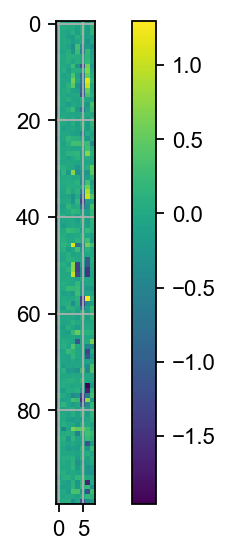

In [107]:
plt.imshow(S[:100])
plt.colorbar()

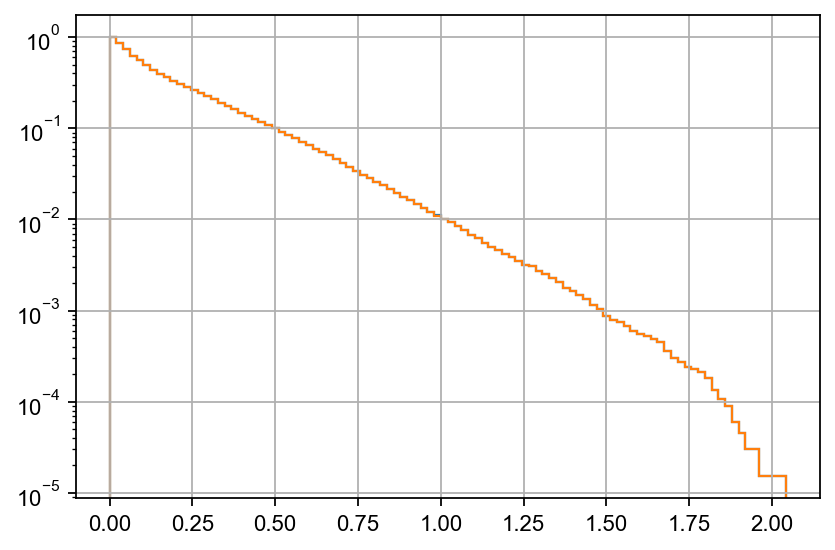

In [137]:
err_raw = (np.array(y1_hard_list) - np.array(y1_soft_list)).reshape(-1)
err_ecc = (np.array(y1_ecc_list) - np.array(y1_soft_list)).reshape(-1)
# err_ecc = (np.array(y1_ecc_list) - np.array(y1_hard_list)).reshape(-1)


_ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
        label='RAW', bins=100)

_ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
        label='ECC correction', bins=100)

plt.yscale('log')

In [136]:
max(abs(err_ecc))

1.006910539972468

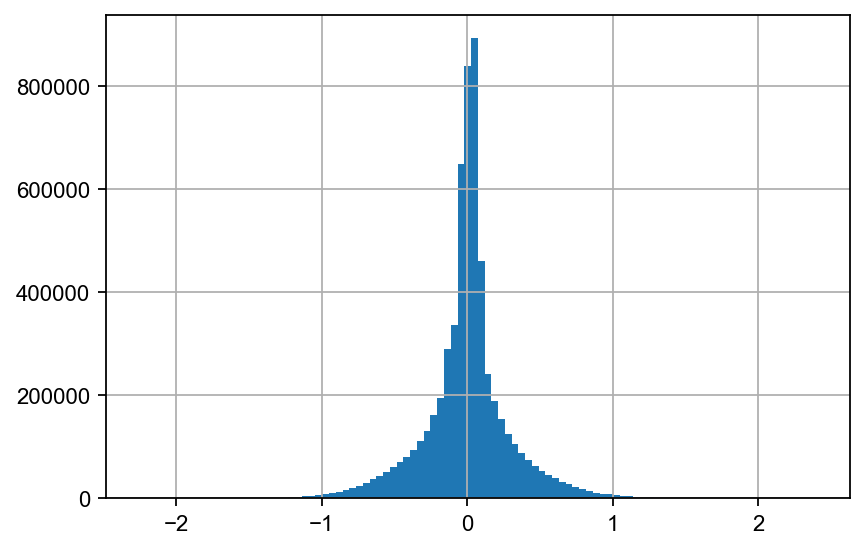

In [79]:
_ = plt.hist(err_ecc, 100)

Text(0, 0.5, 'Accuracy (%)')

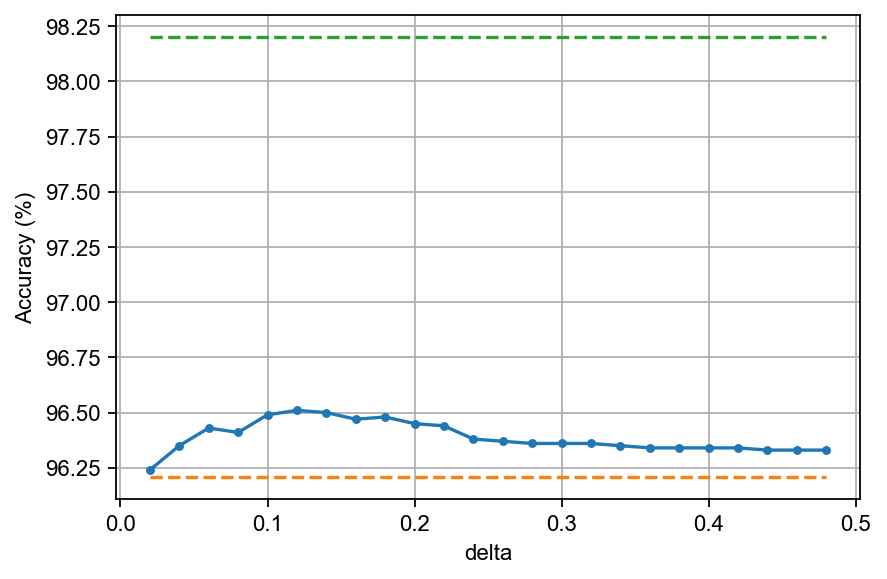

In [56]:
plt.plot(delta_list, np.array(acc_list)*100, '.-')

plt.plot(delta_list, [96.21 for _ in delta_list], '--')
plt.plot(delta_list, [98.20 for _ in delta_list], '--')

plt.xlabel('delta')
plt.ylabel('Accuracy (%)')